In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

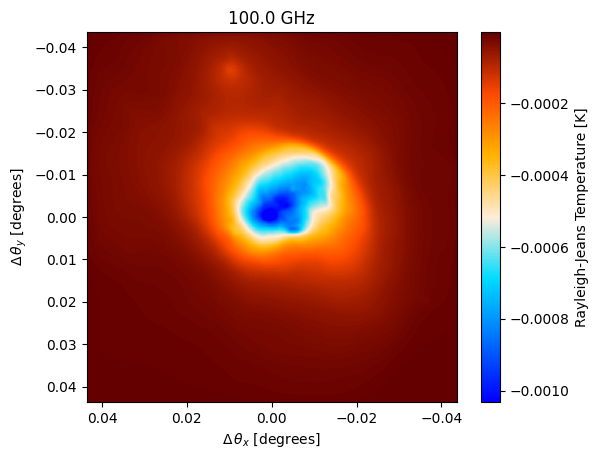

In [3]:
map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

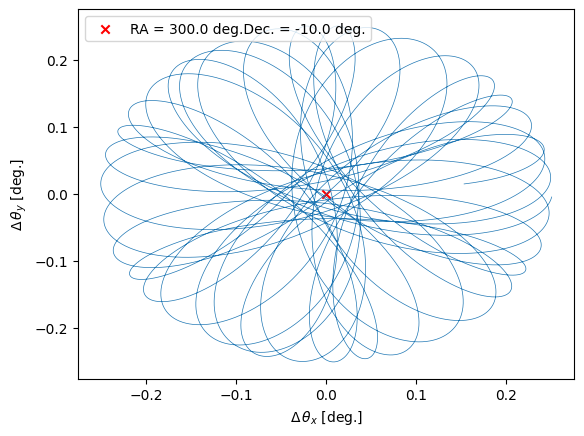

In [4]:
# MUSTANG:
# plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
#                       scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
#                       duration=600, # integration time in seconds
#                       sample_rate=50, # in Hz
#                       scan_center=(150, 10), # position in the sky
#                       frame="ra_dec")

# ATLAST:
plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                      duration=60, # in seconds
                    #   sample_rate=225, # in Hz
                      sample_rate=100, # in Hz
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")

plan.plot()

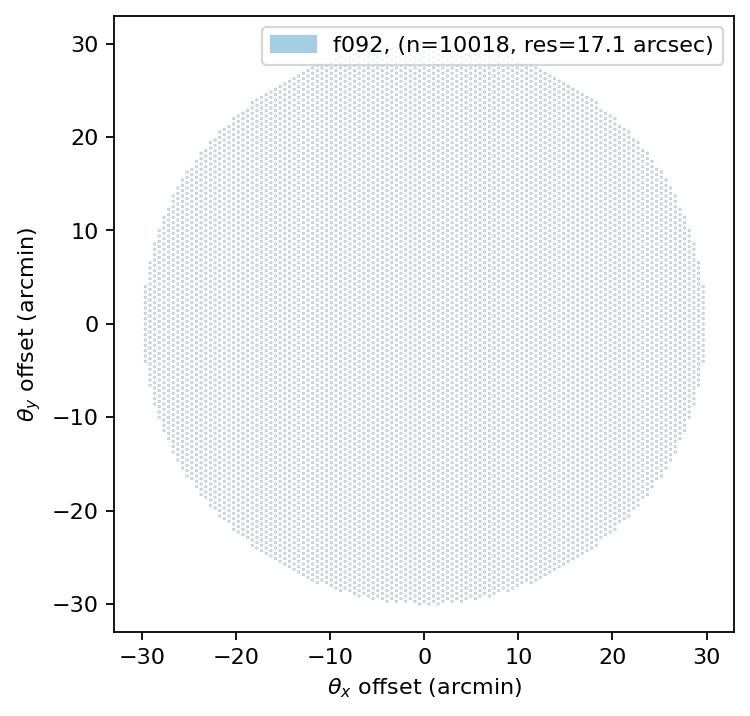

In [5]:
# MUSTANG:
# instrument = maria.get_instrument('MUSTANG-2')

#ATLAST
from maria.instrument import Band

f090 = Band(center=92, # in GHz
            width=40.0,
            knee=1,
            sensitivity=6e-5) # in K sqrt(s)

array = {"field_of_view": 1.0, "bands": [f090]}
instrument = maria.get_instrument(array=array, primary_size=50, beam_spacing = 2)

instrument.plot()

In [11]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                      #  atmosphere="2d",
                    #    cmb="generate",
                      )

tod = sim.run()

2024-07-19 11:13:32.406 INFO: Constructed instrument.
2024-07-19 11:13:32.407 INFO: Constructed plan.
2024-07-19 11:13:32.408 INFO: Constructed site.
2024-07-19 11:13:32.536 INFO: Constructed boresight.
2024-07-19 11:13:32.755 INFO: Constructed offsets.


Initialized base in 349 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

HERE shape (217, 30000)
HERE 2 shape (217, 30000)


In [13]:
# data = tod.components['atmosphere'].compute()
# data.shape

data = tod.data.compute()
data.shape

(217, 30000)

In [14]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# # from https://gist.github.com/zonca/6515744
# cmb_cmap = ListedColormap(
#     np.loadtxt(f"/scratch/users/jwuerzin/CMB_denoising/maria/maria/map/Planck_Parchment_RGB.txt") / 255.0, name="cmb_two"
# )
# cmb_cmap.set_bad("white")

# mpl.colormaps.register(cmb_cmap)

cmb_cmap = plt.get_cmap('cmb')
# cmb_cmap = plt.get_cmap('PRGn')

Making plot for timestep: 0


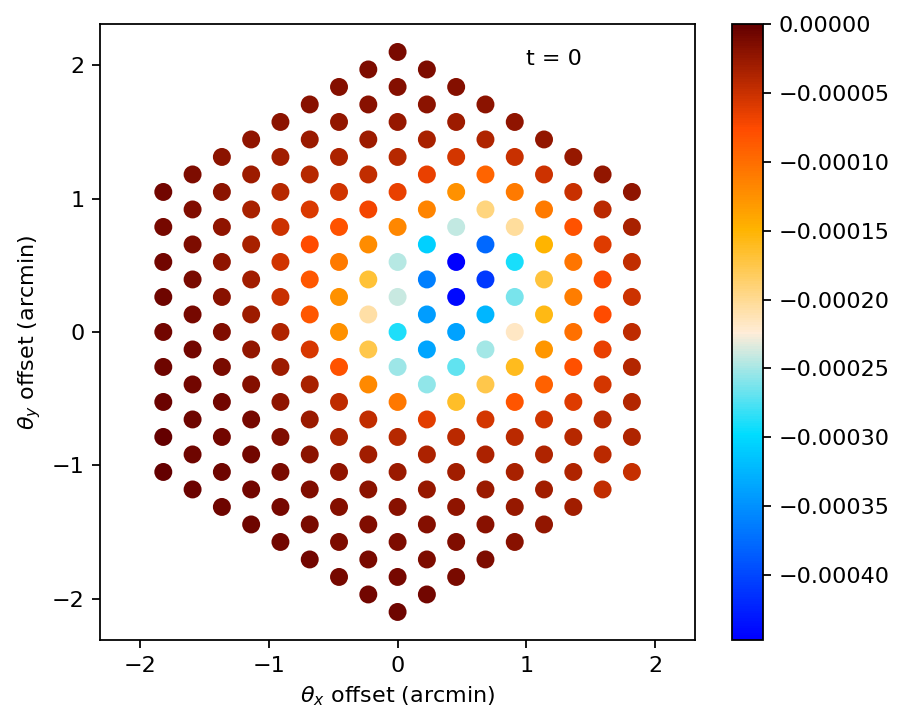

In [17]:
from matplotlib.collections import EllipseCollection
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
# import matplotlib.cm as cm

from maria.tod.coords import Angle

def plot_time(instrument, data, timestep=0):
        # HEX_CODE_LIST = [
        #     mpl.colors.to_hex(mpl.colormaps.get_cmap("Paired")(t))
        #     for t in [*np.linspace(0.05, 0.95, 12)]
        # ]
        print(f"Making plot for timestep: {timestep}")


        fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=160)

        fwhms = Angle(instrument.fwhm)
        offsets = Angle(instrument.offsets)

        # legend_handles = []
        for iub, uband in enumerate(instrument.ubands):
            band_mask = instrument.dets.band_name == uband

            # band_color = HEX_CODE_LIST[iub]

            norm = mcolors.Normalize(vmin=np.min(data[:,timestep]), vmax=np.max(data[:,timestep]))
            atmos_color = cmb_cmap(norm(data[:,timestep]))

            # atmos_color = cmb_cmap(data[:,0])

            # ellipses = EllipseCollection(
            #         widths=getattr(fwhms, offsets.units)[band_mask],
            #         heights=getattr(fwhms, offsets.units)[band_mask],
            #         angles=0,
            #         units="xy",
            #         # facecolors=band_color,
            #         facecolors=atmos_color,
            #         # edgecolors="face",
            #         lw=1e-1,
            #         # alpha=0.5,
            #         offsets=getattr(offsets, offsets.units)[band_mask],
            #         transOffset=ax.transData,
            #         cmap=cmb_cmap,
            #     )

            # ax.add_collection(ellipses)

            # fig.colorbar(im, ax=ax)

            # legend_handles.append(
            #     Patch(
            #         label=f"{uband}, (n={band_mask.sum()}, "
            #         f"res={getattr(fwhms, fwhms.units)[band_mask].mean():.01f} {fwhms.units})",
            #         color=band_color,
            #     )
            # )

            # print(*getattr(offsets, offsets.units)[band_mask].T.shape)
            # print(data[:,0].shape)

            im = ax.scatter(
                *getattr(offsets, offsets.units)[band_mask].T,
                label=uband,
                s=60,
                # color=atmos_color,
                c=data[:,timestep],
                cmap=cmb_cmap
            )

        fig.colorbar(im)
        ax.set_xlabel(rf"$\theta_x$ offset ({offsets.units})")
        ax.set_ylabel(rf"$\theta_y$ offset ({offsets.units})")
        # ax.legend(handles=legend_handles)

        xls, yls = ax.get_xlim(), ax.get_ylim()
        cen_x, cen_y = np.mean(xls), np.mean(yls)
        wid_x, wid_y = np.ptp(xls), np.ptp(yls)
        radius = 0.5 * np.maximum(wid_x, wid_y)

        ax.set_xlim(cen_x - radius, cen_x + radius)
        ax.set_ylim(cen_y - radius, cen_y + radius)
        
        plt.text(1, 2., f"t = {timestep}")
        
        # plt.show()
        return fig
        
fig = plot_time(instrument, data)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import io

# Create a list to hold the frames
frames = []

# Generate and capture individual frames
num_frames = 30000
nskip = 100

for i in range(0, num_frames, nskip):
    
    fig = plot_time(instrument, data, timestep=i)
    
    # Capture the plot as an image in memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    
    # Create an image from the buffer
    buf.seek(0)
    img = Image.open(buf)
    frames.append(img)

# Save the frames as a GIF
frames[0].save('testgif.gif', save_all=True, append_images=frames[1:], duration=1, loop=0)

Making plot for timestep: 0
Making plot for timestep: 100


Making plot for timestep: 200
Making plot for timestep: 300
Making plot for timestep: 400
Making plot for timestep: 500
Making plot for timestep: 600
Making plot for timestep: 700
Making plot for timestep: 800
Making plot for timestep: 900
Making plot for timestep: 1000
Making plot for timestep: 1100
Making plot for timestep: 1200
Making plot for timestep: 1300
Making plot for timestep: 1400
Making plot for timestep: 1500
Making plot for timestep: 1600
Making plot for timestep: 1700
Making plot for timestep: 1800
Making plot for timestep: 1900
Making plot for timestep: 2000
Making plot for timestep: 2100
Making plot for timestep: 2200
Making plot for timestep: 2300
Making plot for timestep: 2400
Making plot for timestep: 2500
Making plot for timestep: 2600
Making plot for timestep: 2700
Making plot for timestep: 2800
Making plot for timestep: 2900
Making plot for timestep: 3000
Making plot for timestep: 3100
Making plot for timestep: 3200
Making plot for timestep: 3300
Making plot for 

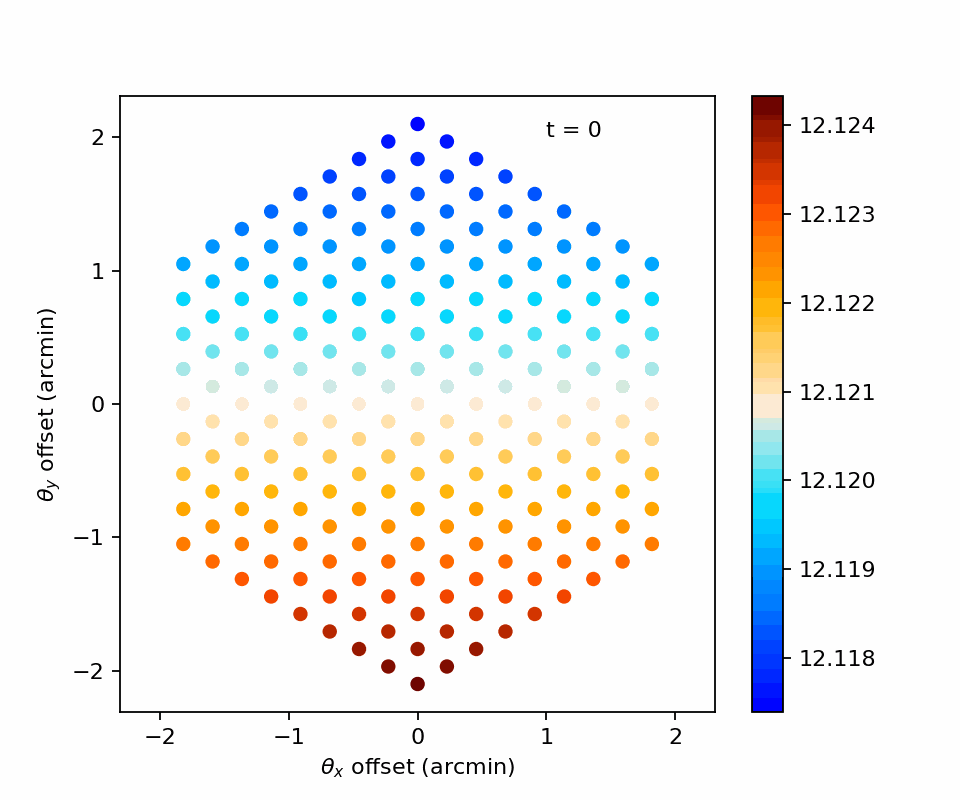

In [10]:
from IPython.display import Image as IPImage, display

display(IPImage(open('testgif.gif', 'rb').read()))